## Project title: What is the payback time of Australian residential solar systems?
#### The aim of this project is to analyse the payback time of solar systems installed on the residential rooftops in Australia. The calculated payback time is compared to the benchmark in published reference. The results show that the customers in the dataset outperformed than the benchmark in all system sizes.


### Table of Contents

* [Section 1.  Import dataset](#section1)
    * [1.1 Read csv files](#section_1_1)
    * [1.2 Clean data](#section_1_2)
* [Section 2. Exploratory data analysis](#section2)
    * [2.1 Solar generation profile](#section_2_1)
    * [2.2 Annual energy generation and consumption](#section_2_2)
* [Section 3. Calculate payback time](#section3)
    * [3.1 Cost model and reference](#section_3_1)
    * [3.1 Feed in and consumed](#section_3_2)
    * [3.2 All time and smart home plans](#section_3_3)
* [Section 4. Analysis of payback time](#section4)
    * [4.1 Peak sun hours](#section_4_1)
    * [4.2 Solar investment](#section_4_2)
    * [4.3 Summary](#section_4_3)


## Section 1.  Import dataset <a class="anchor" id="section1"></a> 

 - The dataset of Australian residential rooftop solar systems is sourced from Ausgrid's electricity network. The dataset consists of one year of energy data (in 30 minutes interval) of randomly selected 300 customers collected in three years from 1 July 2010 to 30 June 2013. In this project, only the last year's data is evaluated (i.e., from 1 July 2012 to 30 June 2013).
 
 - The link to the dataset source is:
 https://www.ausgrid.com.au/Industry/Our-Research/Data-to-share/Solar-home-electricity-data
 

### Section 1.1 Read csv files <a class="anchor" id="section_1_1"></a>


 - Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
df_solar = pd.read_csv('Solar home data 2012.csv')

# change column names to lower case, replace space with '_'
df_solar.columns = df_solar.columns.str.lower().str.replace('?','').str.replace('*','').str.replace(' ','_')

time_columns = df_solar.columns[df_solar.columns.get_loc('0:30'):df_solar.columns.get_loc('0:00')+1]

# change date to type datetime
df_solar['date'] = pd.to_datetime(df_solar['date'], format = '%d/%m/%Y')

df_solar['month'] = df_solar['date'].dt.month

df_solar['daily_sum'] = df_solar[time_columns].sum(axis='columns')


In [3]:
df_solar.columns

Index(['customer', 'generator_capacity', 'postcode', 'consumption_category',
       'date', '0:30', '1:00', '1:30', '2:00', '2:30', '3:00', '3:30', '4:00',
       '4:30', '5:00', '5:30', '6:00', '6:30', '7:00', '7:30', '8:00', '8:30',
       '9:00', '9:30', '10:00', '10:30', '11:00', '11:30', '12:00', '12:30',
       '13:00', '13:30', '14:00', '14:30', '15:00', '15:30', '16:00', '16:30',
       '17:00', '17:30', '18:00', '18:30', '19:00', '19:30', '20:00', '20:30',
       '21:00', '21:30', '22:00', '22:30', '23:00', '23:30', '0:00',
       'row_quality', 'month', 'daily_sum'],
      dtype='object')

In [4]:
df_solar.shape

(268557, 56)

### Section 1.2 Clean data <a class="anchor" id="section_1_2"></a>

In [5]:
# remove erroneous data
# customer 2: only 284 days of data
# customer 6,24,57,91,92,97,116,138,158,187,252,266: Zero solar generation in some months

erroneous_customer = [2,6,24,57,91,92,97,116,138,158,187,252,266]

df_solar = df_solar[~df_solar['customer'].isin(erroneous_customer)]
df_solar.shape

(257543, 56)

## Section 2.  Exploratory data analysis <a class="anchor" id="section2"></a> 

### Section 2.1 Solar generation profile <a class="anchor" id="section_2_1"></a>

#### 1. Daily profile of solar generation


In [6]:
def plot_daily_profile(df, category) :
    """ graph the daily profile in 12 months (Jan to Dec) of the selected consumption category """
        
    time_columns = df.columns[df.columns.get_loc('0:30'):df.columns.get_loc('0:00')+1]
    cat_df = df.loc[df['consumption_category']==category].set_index('month')

    sns.reset_defaults()
    sns.set_style("darkgrid")
    monthly_energy = np.zeros(12)

    fig, axs = plt.subplots(3, 4, sharex='all', sharey='all', figsize=[6*4,5*3])
    count = 0
    for count in range(12):
        mon = (count+0) % 12 + 1
        #print(mon, count//4, count%4)
        mon_dist = df.loc[(df['consumption_category']==category) & (df['month']==mon)]
        monthly_energy[mon-1] = cat_df.loc[mon,time_columns].T.sum().sum()
        axs[count//4, count%4].plot(cat_df.loc[mon,time_columns].T, alpha = 0.4)

        axs[count//4, count%4].plot(cat_df.loc[mon,time_columns].T.mean(axis='columns'), linewidth = 4, color = 'orange')
        axs[count//4, count%4].set_title(calendar.month_abbr[mon], fontsize = 14, fontweight = 'bold')
        if (count%4 == 0) :
            axs[count//4,0].set_ylabel('Energy (kWh)', fontsize = 14, fontweight='bold')

    axs[2,0].set_xticklabels('')
    plt.show()
    
    #fig_name = 'cid_' + str(customer_id) + '_monthly_' + str.lower(category) + '.png'
    #fig.savefig(fig_name, transparent=False, bbox_inches='tight', dpi=300)

    print(monthly_energy)

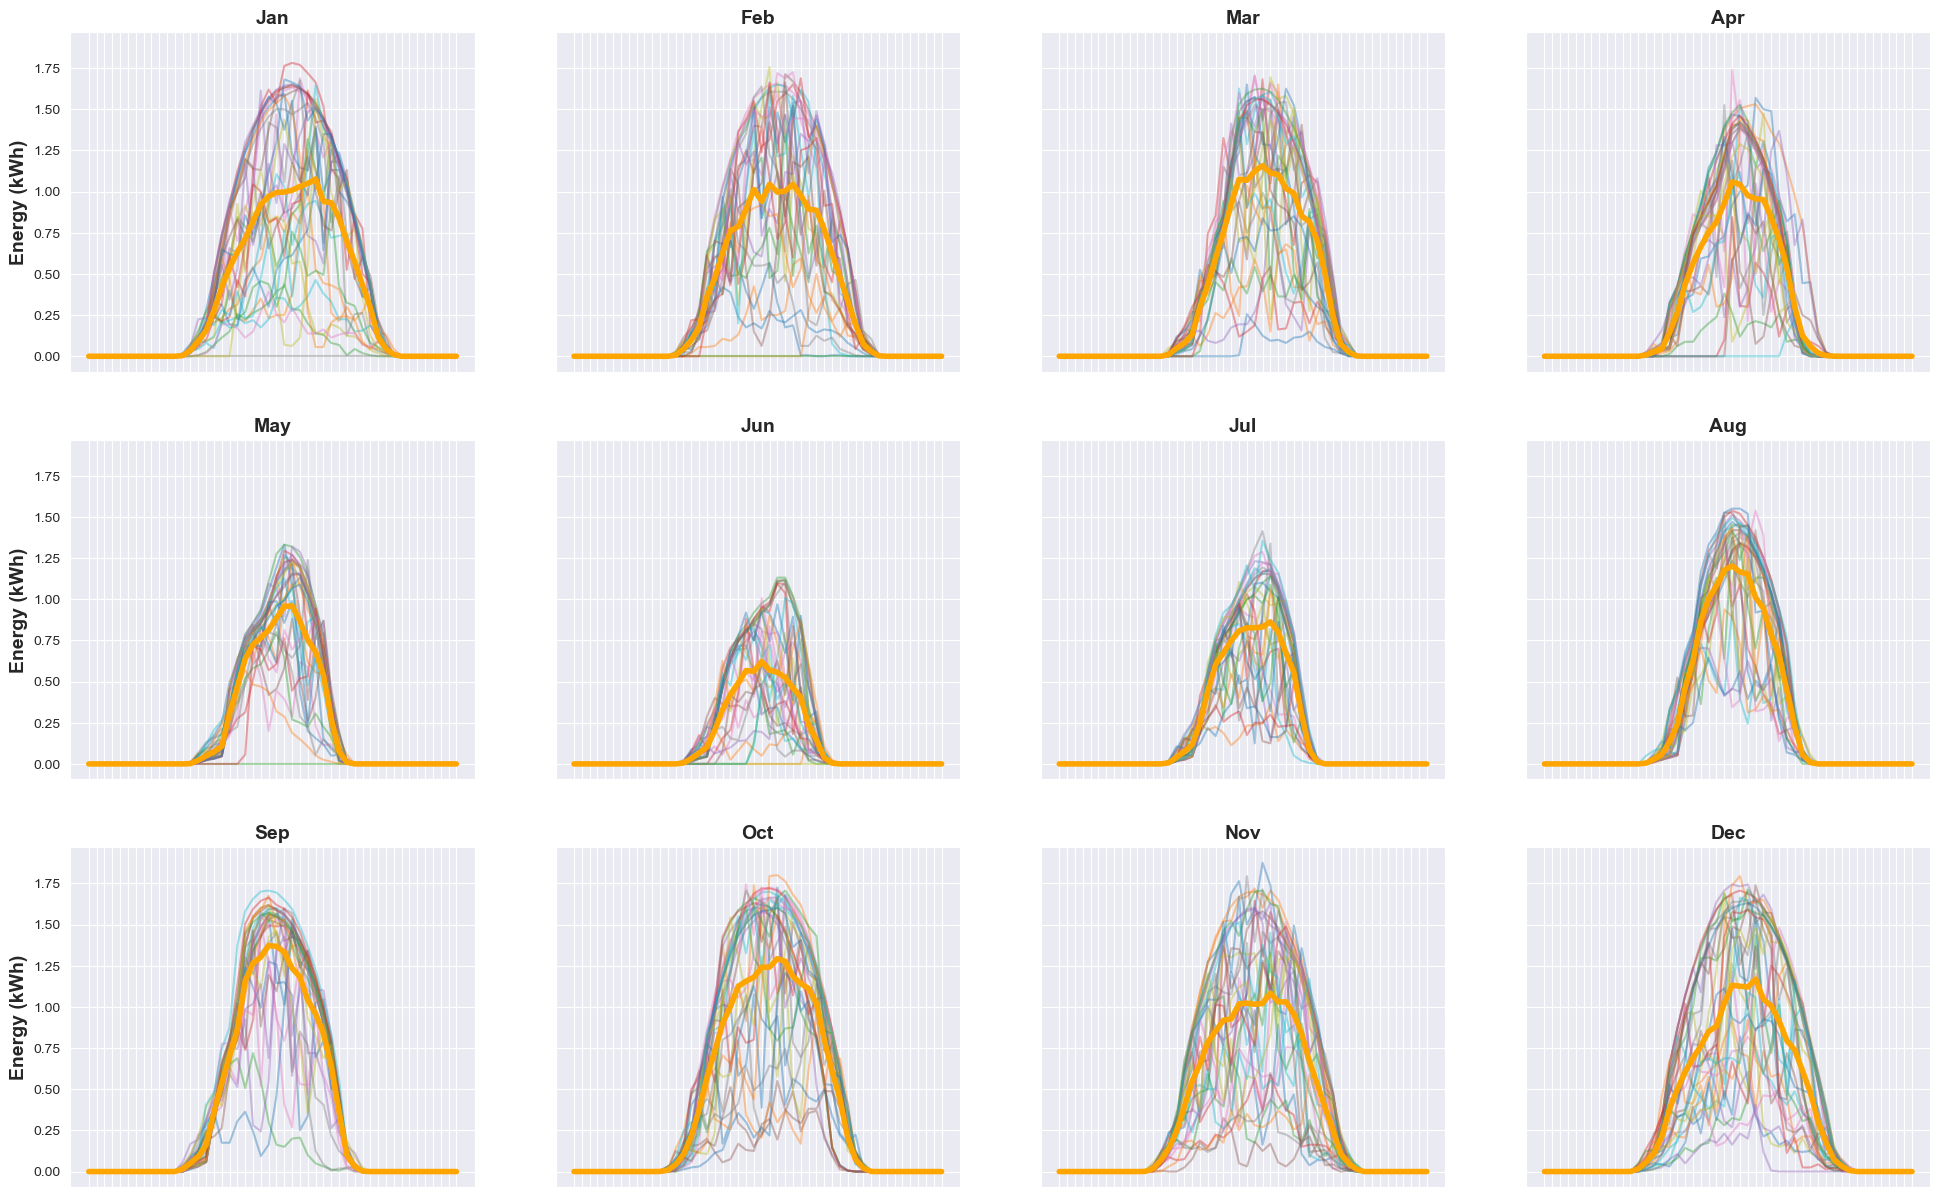

[515.298 435.181 469.512 367.17  309.174 190.301 295.702 413.76  509.115
 591.121 497.133 521.74 ]


In [7]:
customer_id = 1
plot_daily_profile(df_solar[df_solar['customer']==customer_id], 'GG')

#### 2. Monthly profile of solar generation

In [47]:
def graph_monthly_profile(customer_id, category, str_ylabel) :
    """ graph the montly profile of selected consumption category """

    cid = df_solar.loc[(df_solar['customer']==customer_id) & (df_solar['consumption_category']==category)]

    cid_monthly = cid.groupby('month').mean().reset_index()
    cid_monthly['month_abbr'] = cid_monthly['month'].apply(lambda x: calendar.month_abbr[x])
    cid_monthly = cid_monthly.T
    cid_monthly.columns = cid_monthly.loc['month_abbr',:]
    cid_monthly = cid_monthly.loc['0:30':'0:00'].apply(pd.to_numeric, errors='ignore')

    sns.set_style("darkgrid")
    custom_palette = ['#FF2020', '#F03848', '#C05070', '#986898', '#7050C0', '#4838E0',
                      '#2020FF', '#4850C0', '#708098', '#98C070', '#60F048', '#20FF20']
    linestyle = ['-','--','-:',':','-','--','-:',':','-','--','-:',':']
    dashstyle = [(1,0), (1,1), (4,2), (2,1,3,1),
                 (1,1,5,1), (1,2), (6,1), (3,1),
                 (1,1,1,1,4,1), (2,1,1,1,3,1), (2,1,2,1,1,1,1,1), (4,1)]
    
    sns.set_palette(custom_palette)

    fig, ax = plt.subplots(figsize=[8,5])
    _ = sns.lineplot(data = cid_monthly, hue='month_abbr', dashes = dashstyle, sort=False)
    _ = plt.xticks(range(1,48,2), rotation = 90)
    _ = plt.xlabel('Time', fontsize=14, fontweight='bold')
    _ = plt.ylabel(str_ylabel, fontsize=14, fontweight='bold')
    
    if category == 'GC':
        _ = ax.legend(fontsize=13, bbox_to_anchor=(1, 1.01))
    else :
        _ = ax.legend(fontsize=13)
    
    plt.margins(0.02)
    plt.show()

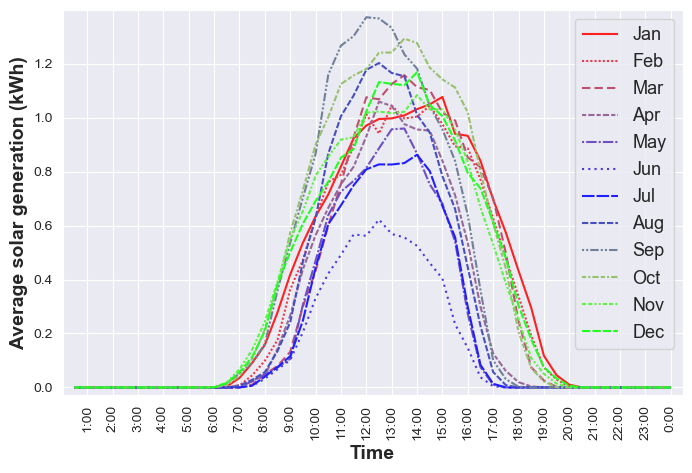

In [48]:
customer_id = 1
consumption_category = 'GG'
y_labels = 'Average solar generation (kWh)'

graph_monthly_profile(customer_id, consumption_category, y_labels)

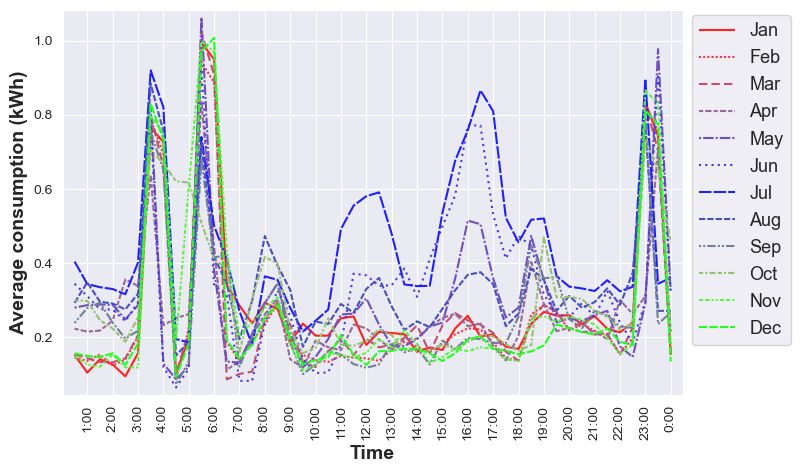

In [49]:
customer_id = 1
consumption_category = 'GC'
y_labels = 'Average consumption (kWh)'

graph_monthly_profile(customer_id, consumption_category, y_labels)

### Section 2.2 Annual energy generation and consumption <a class="anchor" id="section_2_2"></a>

 - Aggregated energy per month

In [11]:
def plot_annual_energy_monthly_profile(df_solar, customer_id) :
    """ graph annual energy in each month in three consumption categories"""
    sns.set_style("darkgrid")
    sns.set_palette('Set1', 2, .75)
    sns.color_palette("hls", 8)

    df = df_solar[df_solar['customer']==customer_id].groupby(['month','consumption_category'])['daily_sum'].sum().reset_index()
    df['month_name'] = df['month'].apply(lambda x: calendar.month_abbr[x])
    
    fig, ax = plt.subplots()
    _ = sns.lineplot(data=df, x='month_name', y='daily_sum', hue='consumption_category', sort=False, marker='.', markersize=10)
    _ = plt.xlabel('Month', fontsize=14, fontweight='bold')
    _ = plt.ylabel('Energy (kWh)', fontsize=14, fontweight='bold')
    if (df['consumption_category'].nunique() <= 2) : # No CL data
        _ = plt.legend(['General Consumption', 'Solar generation'], fontsize=13)
    else :
        _ = plt.legend(['Controlled load Consumption', 'General Consumption', 'Solar generation'], fontsize=13)
    _ = plt.ylim(df['daily_sum'].min()/2, df['daily_sum'].max()*1.8)
    _ = plt.ylim(0, df['daily_sum'].max()*1.6)
    _ = plt.title('Customer #'+str(customer_id), fontsize=14, fontweight='bold')
    #plt.subplots_adjust(top=2)
    plt.margins(0.02)
    plt.show()


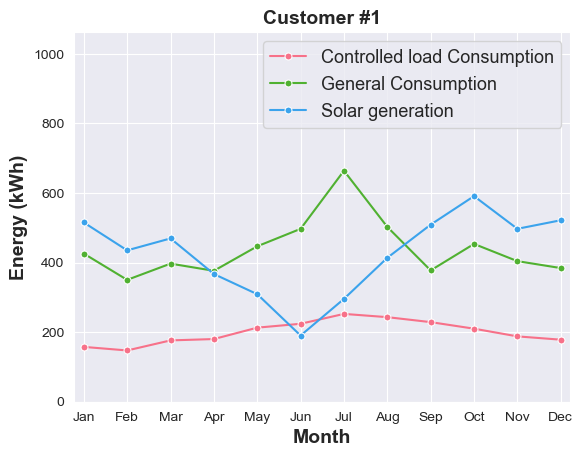

In [51]:
customer_id = 1
plot_annual_energy_monthly_profile(df_solar, customer_id)

 - Aggregated annual energy in daily profile

In [13]:
df_time_profile = df_solar.groupby(['customer','consumption_category'], as_index=False).sum()
df_time_profile.drop(columns=['generator_capacity','postcode','row_quality'], inplace=True)

grouped = df_solar.groupby(['customer','consumption_category']) \
                  .agg(generator_capacity = ('generator_capacity','first'),
                       postcode = ('postcode','first')) \
                  .reset_index()

In [14]:
df_time_profile.head()

,customer,consumption_category,0:30,1:00,1:30,2:00,2:30,3:00,3:30,4:00,...,20:30,21:00,21:30,22:00,22:30,23:00,23:30,0:00,month,daily_sum
0,1,CL,224.449,406.046,377.849,247.968,203.527,186.467,108.065,104.535,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,196.102,2382,2399.317
1,1,GC,86.580,83.521,80.553,78.759,74.327,90.546,288.471,211.366,...,93.136,91.743,92.869,80.310,84.912,251.018,240.062,91.536,2382,5279.884
2,1,GG,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2382,5115.207
3,3,CL,75.435,72.083,51.876,25.933,14.998,4.292,3.523,6.486,...,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,2382,296.387
4,3,GC,53.470,42.497,35.575,29.392,24.816,24.106,22.909,23.518,...,61.269,62.360,63.713,62.087,66.647,61.811,51.849,51.109,2382,1948.262


In [15]:
df_time_profile = df_time_profile.merge(grouped,
                                        how = 'left',
                                        on = ['customer', 'consumption_category'])
df_time_profile

,customer,consumption_category,0:30,1:00,1:30,2:00,2:30,3:00,3:30,4:00,...,21:30,22:00,22:30,23:00,23:30,0:00,month,daily_sum,generator_capacity,postcode
0,1,CL,224.449,406.046,377.849,247.968,203.527,186.467,108.065,104.535,...,0.000,0.000,0.000,0.000,0.000,196.102,2382,2399.317,3.78,2076
1,1,GC,86.580,83.521,80.553,78.759,74.327,90.546,288.471,211.366,...,92.869,80.310,84.912,251.018,240.062,91.536,2382,5279.884,3.78,2076
2,1,GG,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,2382,5115.207,3.78,2076
3,3,CL,75.435,72.083,51.876,25.933,14.998,4.292,3.523,6.486,...,0.000,0.001,0.000,0.000,0.000,0.000,2382,296.387,1.00,2263
4,3,GC,53.470,42.497,35.575,29.392,24.816,24.106,22.909,23.518,...,63.713,62.087,66.647,61.811,51.849,51.109,2382,1948.262,1.00,2263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,299,GC,94.578,80.415,75.247,71.493,71.981,71.394,72.653,69.509,...,321.761,281.840,245.468,188.889,143.998,117.536,2382,10270.760,1.00,2076
703,299,GG,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,2382,1882.347,1.00,2076
704,300,CL,443.142,835.183,683.815,439.324,210.137,94.648,30.782,10.108,...,0.000,0.000,0.000,0.000,0.000,460.368,2382,4233.572,3.36,2086
705,300,GC,261.864,155.884,99.830,85.024,77.443,108.250,108.525,77.650,...,233.764,217.453,204.524,225.542,247.569,322.019,2382,9186.398,3.36,2086


In [16]:
def plot_annual_energy_in_daily_profile(customer_id, df) :
    """ plot the annual energy generation & consumption in daily profile for customer_id """
    sns.reset_defaults()
    sns.set_style("darkgrid")
    sns.set_palette('Set1', 2, .75)
    sns.color_palette("hls", 8)
    
    time_columns = df.columns[df.columns.get_loc('0:30'):df.columns.get_loc('0:00')+1]

    df = df[df['customer']==customer_id].set_index('consumption_category')
    df = df[time_columns].T

    fig, ax = plt.subplots(figsize=[8,5])
    _ = sns.lineplot(data = df, hue='consumption_category', sort=False, marker='.', markersize=8)
    _ = plt.xlabel('Time', fontsize=14, fontweight='bold')
    _ = plt.ylabel('Annual energy (kWh)', fontsize=14, fontweight='bold')
    _ = plt.legend(['Controlled load Consumption', 'General Consumption', 'Solar generation'], fontsize=13)
    _ = plt.ylim(0-10, df.max().max()+120)
    _ = plt.xticks(range(1,48,2), rotation=90)
    x = df.index
    y1= df.loc[:,'GC']
    y2= df.loc[:,'GG']
    _ = ax.fill_between(x, 0, y2, where=y2 >= 0, facecolor='#A0A0A0')
    _ = ax.fill_between(x, y1, y2, where=y2 >= y1, facecolor='#C0C0C0', interpolate=True)
    plt.margins(0.02)
    plt.show()

    # export figure
#    fig_name = 'cid_' + str(customer_id) + '_annual_energy_daily_profile.png'
#    fig.savefig(fig_name, transparent=False, bbox_inches='tight', dpi=300)


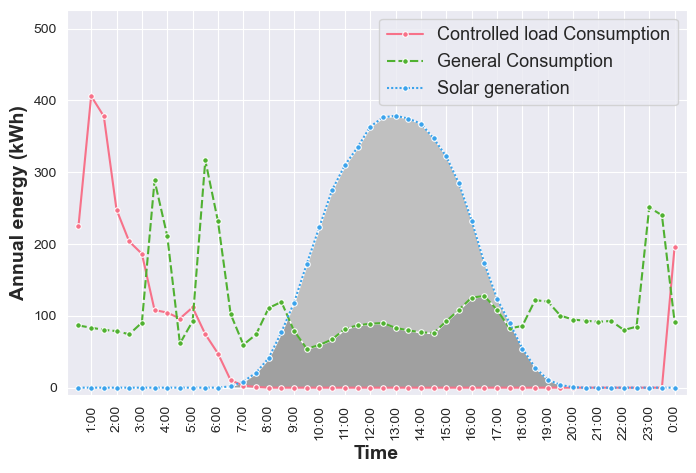

In [17]:
customer_id = 1
plot_annual_energy_in_daily_profile(customer_id, df_time_profile)

As shown in the graph above, the solar generation is divided into two regions. The dark grey area, where the solar generation is lower than the consumption, the electricity is provided by the solar system. When the solar system generates more electricity than consumption, the excess energy (i.e., the light grey area) is fed back to the grid. Different electricity rates will be used to calculate the payback time in the next section.

## Section 3.  Calculate payback time <a class="anchor" id="section3"></a> 
### Section 3.1 Cost model and reference <a class="anchor" id="section_3_1"></a>

 - The cost model of the solar systems is based on Table 6 of the following reference paper:

Imteaz, Monzur Alam, and Amimul Ahsan. "Solar panels: Real efficiencies, potential productions and payback periods for major Australian cities." Sustainable Energy Technologies and Assessments 25 (2018): 119-125.

Therefore, solar panel cost after gov rebates can be expressed by:

     solar_cost = 1161.7 * (system size in kW) + 2073.7

### Section 3.2 Feed in and consumed <a class="anchor" id="section_3_2"></a>


 - Create the data frame for payback time

In [19]:
df_payback  = df_solar.groupby(['customer']) \
                      .agg(generator_capacity = ('generator_capacity','first'),
                           postcode = ('postcode','first')) \
                      .reset_index()

 - Calcualte annual generation and consumption

In [20]:
total = df_solar[df_solar['consumption_category']=='GG'].groupby(['customer']) \
                                                        .agg(generation = ('daily_sum','sum')) \
                                                        .reset_index()
df_payback = df_payback.merge(total, how = 'left', on = 'customer')

total = df_solar[df_solar['consumption_category']!='GG'].groupby(['customer']) \
                                                        .agg(consumption = ('daily_sum','sum')) \
                                                        .reset_index()
df_payback = df_payback.merge(total, how = 'left', on = 'customer')

df_payback.head()

,customer,generator_capacity,postcode,generation,consumption
0,1,3.78,2076,5115.207,7679.201
1,3,1.00,2263,1556.220,2244.649
2,4,1.00,2220,1326.593,5053.187
3,5,1.00,2261,1262.292,5455.108
4,7,2.16,2259,3163.384,4919.249


 - Calculate peak sun hours

In [21]:
df_payback['psh'] = df_payback['generation'] / df_payback['generator_capacity'] / 365.0


 - Calculate system cost

In [22]:
df_payback['cost'] = 1161.7 * df_payback['generator_capacity'] + 2073.7


In [23]:
df_payback.set_index('customer', inplace = True)
df_payback.head()

,generator_capacity,postcode,generation,consumption,psh,cost
customer,,,,,,
1,3.78,2076,5115.207,7679.201,3.707478,6464.926
3,1.00,2263,1556.220,2244.649,4.263616,3235.400
4,1.00,2220,1326.593,5053.187,3.634501,3235.400
5,1.00,2261,1262.292,5455.108,3.458334,3235.400
7,2.16,2259,3163.384,4919.249,4.012410,4582.972


In [ ]:
 - Generate the feed_in and consumed profiles 

In [24]:
df_solar.set_index(['customer','date'], inplace = True)
gg = df_solar.loc[df_solar['consumption_category']=='GG'][time_columns]
gc = df_solar.loc[df_solar['consumption_category']=='GC'][time_columns]
df_solar.reset_index(inplace=True)

# feed in energy profile
feed_in = np.maximum(0.0, gg-gc)

# solar generation directly consumed
consumed = gg - feed_in


In [25]:
feed_in  = feed_in.reset_index().groupby('customer',as_index=True).sum()
consumed = consumed.reset_index().groupby('customer',as_index=True).sum()

In [26]:
def calculate_payback_time(col_savings, col_payback) :
    """ calculate the payback time """
    # feed-in savings before 31/12/2016
    savings_feed_in1 = feed_in_tariff1 * feed_in.sum(axis='columns')
    # feed-in savings after 1/1/2017
    savings_feed_in2 = feed_in_tariff2 * feed_in.sum(axis='columns')

    savings_shoulder = consumed.loc[:,:'14:00'].sum(axis='columns') * electricity_shoulder
    savings_peak = consumed.loc[:,'14:30':].sum(axis='columns') * electricity_peak

    annual_saving1 = savings_feed_in1 + savings_shoulder + savings_peak
    annual_saving2 = savings_feed_in2 + savings_shoulder + savings_peak
    df_payback[col_savings] = annual_saving1

    # In the calculation, 4 means the first four years 2012-2016
    payback_time = 4 + (df_payback['cost'] - 4*annual_saving1)/annual_saving2
    df_payback[col_payback] = payback_time


### Section 3.3 All time and smart home plans <a class="anchor" id="section_3_3"></a>

 - There are two energy plans: all time and smart home, which is not specified in the dataset. As the plans differ in the electricity rates, payback time is calculated for each plan.

In [27]:
# Residential - all time

# feed in tariff rate in dollar
feed_in_tariff1 = 0.20  # before 31/12/2016
feed_in_tariff2 = 0.10  # after 1/1/2017

# electricity rate in dollar
electricity_peak = 0.28
electricity_shoulder = 0.28

calculate_payback_time('savings_alltime', 'payback_alltime')


In [28]:
# Residential - SmartHome

# feed in tariff rate in dollar
feed_in_tariff1 = 0.20  # before 31/12/2016
feed_in_tariff2 = 0.10  # after 1/1/2017

# electricity rate in dollar
electricity_peak = 0.52
electricity_shoulder = 0.22

calculate_payback_time('savings_smarthome', 'payback_smarthome')


In [29]:
df_payback

,generator_capacity,postcode,generation,consumption,psh,cost,savings_alltime,payback_alltime,savings_smarthome,payback_smarthome
customer,,,,,,,,,,
1,3.78,2076,5115.207,7679.201,3.707478,6464.926,1123.73260,6.669096,1179.45610,6.200936
3,1.00,2263,1556.220,2244.649,4.263616,3235.400,350.22160,11.539461,365.89600,10.841094
4,1.00,2220,1326.593,5053.187,3.634501,3235.400,336.06676,10.479974,385.56994,8.960131
5,1.00,2261,1262.292,5455.108,3.458334,3235.400,314.01760,11.476577,331.35610,10.771141
7,2.16,2259,3163.384,4919.249,4.012410,4582.972,714.00192,7.458633,750.14208,6.955223
...,...,...,...,...,...,...,...,...,...,...
296,1.08,2087,1446.726,2788.395,3.670030,3328.336,356.22608,10.448932,373.87502,9.859384
297,1.50,2261,1995.848,6016.428,3.645384,3816.250,494.16496,8.450718,525.79354,7.850016
298,1.02,2216,1410.584,3119.837,3.788837,3258.634,352.36864,10.181895,384.00406,9.208052


   - Output the results of payback time to csv file

In [30]:
# save payback dataframe to csv
df_payback.to_csv('solar_payback_new.csv')


In [56]:
df_payback['payback_alltime'].mean() , df_payback['payback_smarthome'].mean()

(9.259808154838163, 8.511696003343475)

In [32]:
col_payback = 'payback_smarthome'
df_payback[col_payback].min(), df_payback[col_payback].max()


(3.9514682069578413, 16.036674878724003)

- scatter plot of payback time with two different energy plans

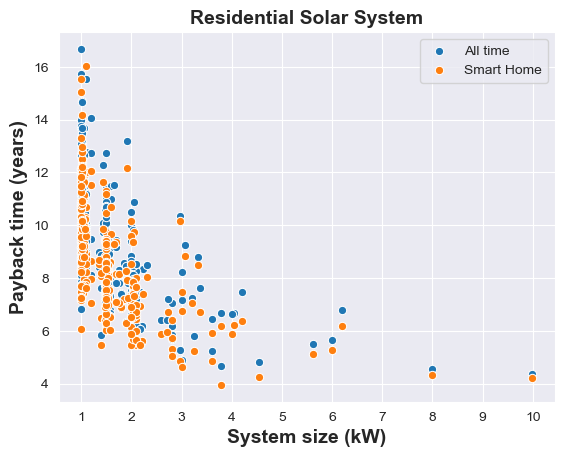

In [33]:
sns.reset_defaults()
sns.set_style("darkgrid")
#sns.set_palette('Set1', 2, .75)
#sns.color_palette("hls", 8)
fig, ax = plt.subplots()
_ = sns.scatterplot(x='generator_capacity', y='payback_alltime', data=df_payback, alpha=0.995)
_ = sns.scatterplot(x='generator_capacity', y='payback_smarthome', data=df_payback, alpha=0.995)
_ = plt.xlabel('System size (kW)', fontsize=14, fontweight='bold')
_ = plt.ylabel('Payback time (years)', fontsize=14, fontweight='bold')
_ = plt.title('Residential Solar System', fontsize=14, fontweight='bold')
_ = plt.xticks(np.arange(1,11,1))
_ = plt.legend(['All time','Smart Home'])
plt.show()


- histogram plot of payback time with two different energy plans

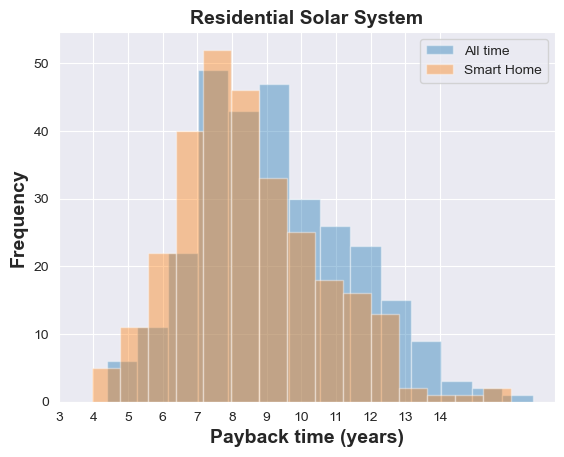

In [34]:
fig, ax = plt.subplots()
_ = sns.distplot(df_payback['payback_alltime'], kde=False)
_ = sns.distplot(df_payback['payback_smarthome'], kde=False)
_ = plt.xlabel('Payback time (years)', fontsize=14, fontweight='bold')
_ = plt.ylabel('Frequency', fontsize=14, fontweight='bold')
_ = plt.title('Residential Solar System', fontsize=14, fontweight='bold')
_ = plt.legend(['All time','Smart Home'])
_ = plt.xticks(np.arange(3,15,1))
plt.show()


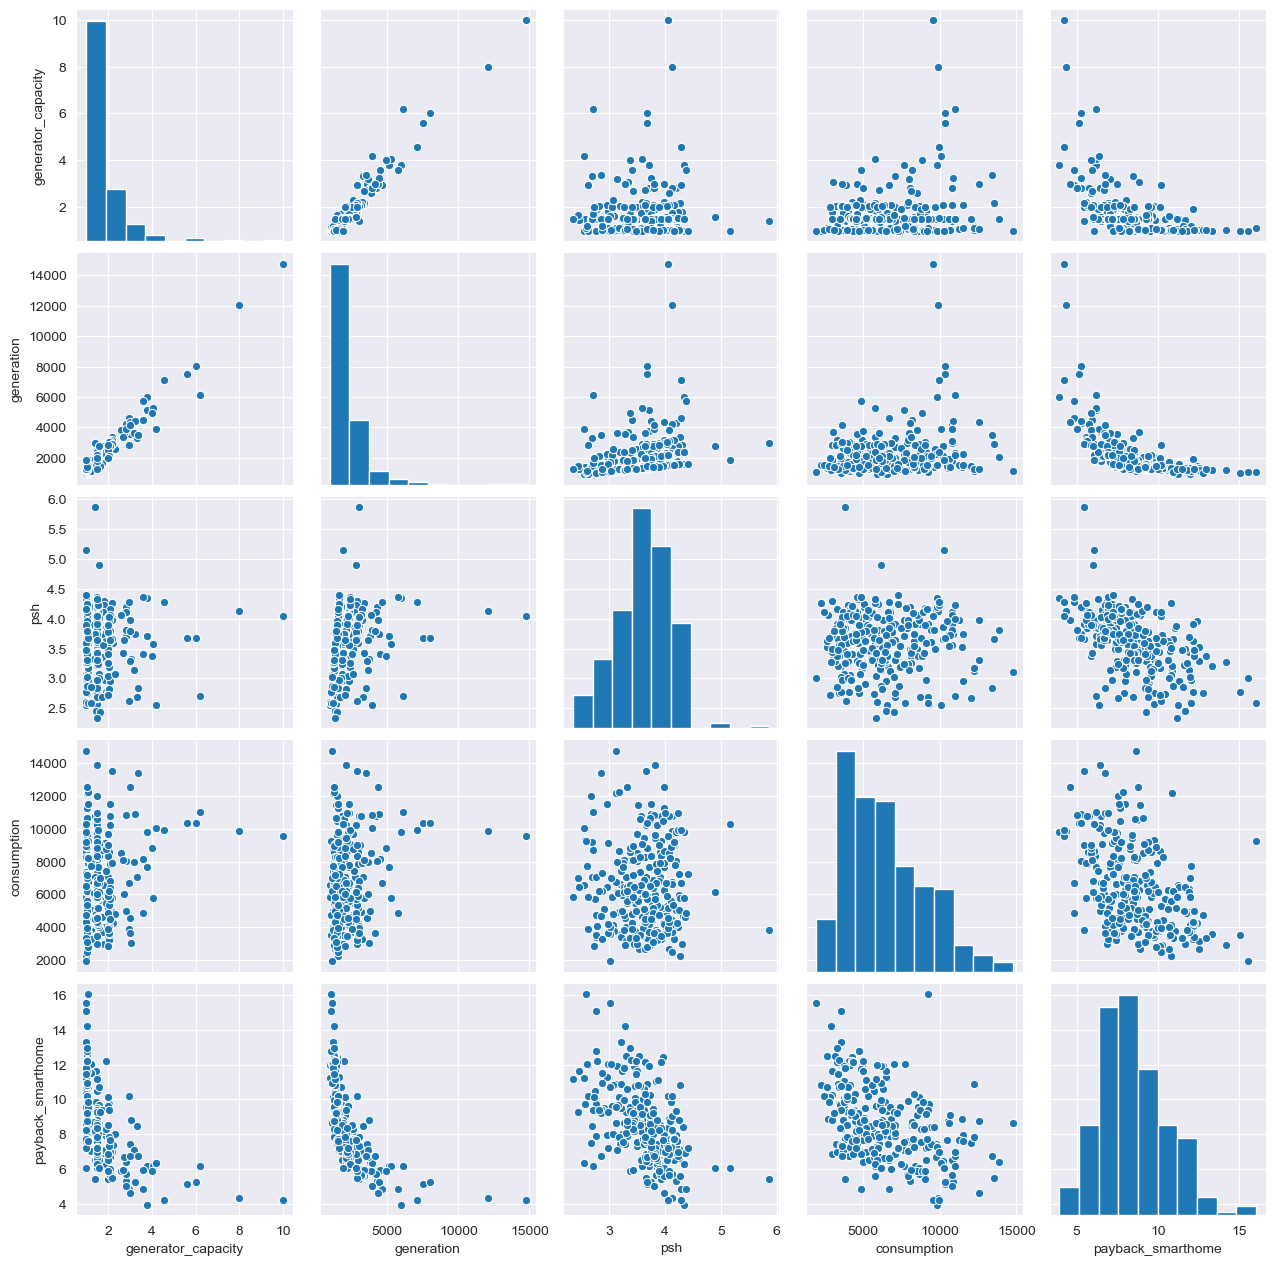

In [35]:
_ = sns.pairplot(df_payback[['generator_capacity','generation','psh','consumption','payback_smarthome']])
plt.show()

- Divide the system size into 6 bins

In [36]:
system_labels = [' 1 kW',' 1.5kW',' 2 kW',' 3 kW',' 4 kW','>5 kW']
system_level = pd.cut(df_payback['generator_capacity'], [0.9, 1.5, 2, 3, 4, 5, 10], labels=system_labels)
df_payback['system_level'] = system_level
df_payback.head()

,generator_capacity,postcode,generation,consumption,psh,cost,savings_alltime,payback_alltime,savings_smarthome,payback_smarthome,system_level
customer,,,,,,,,,,,
1,3.78,2076,5115.207,7679.201,3.707478,6464.926,1123.73260,6.669096,1179.45610,6.200936,3 kW
3,1.00,2263,1556.220,2244.649,4.263616,3235.400,350.22160,11.539461,365.89600,10.841094,1 kW
4,1.00,2220,1326.593,5053.187,3.634501,3235.400,336.06676,10.479974,385.56994,8.960131,1 kW
5,1.00,2261,1262.292,5455.108,3.458334,3235.400,314.01760,11.476577,331.35610,10.771141,1 kW
7,2.16,2259,3163.384,4919.249,4.012410,4582.972,714.00192,7.458633,750.14208,6.955223,2 kW


- payback time bar chart (to compare with benchmark results)

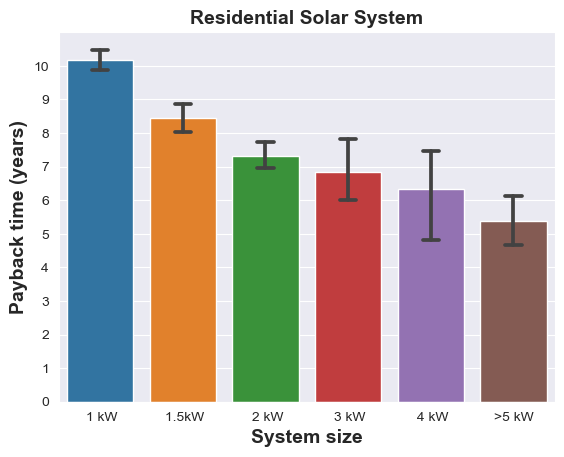

In [37]:
fig, ax = plt.subplots()
_ = sns.barplot(data=df_payback, x='system_level',y='payback_alltime', capsize=.2)
_ = plt.xlabel('System size', fontsize=14, fontweight='bold')
_ = plt.ylabel('Payback time (years)', fontsize=14, fontweight='bold')
_ = plt.title('Residential Solar System', fontsize=14, fontweight='bold')
#_ = plt.legend(system_level)
_ = plt.yticks(np.arange(0,11,1))
plt.show()


- box plot and strip plot of payback time in 6 system sizes

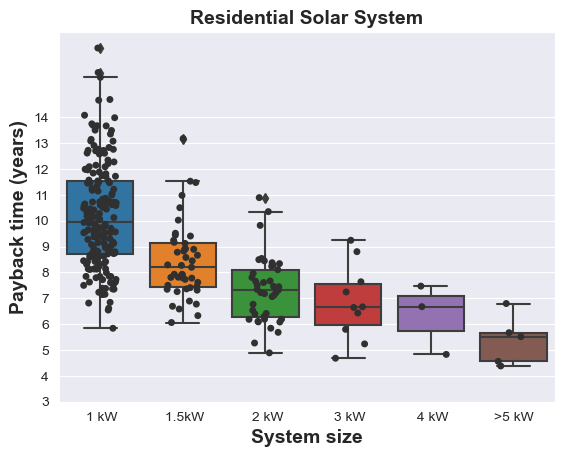

In [38]:
fig, ax = plt.subplots()
_ = sns.boxplot(data=df_payback, x='system_level',y='payback_alltime')
_ = sns.stripplot(data=df_payback, x='system_level',y='payback_alltime', color='#303030', jitter=0.20)
_ = plt.xlabel('System size', fontsize=14, fontweight='bold')
_ = plt.ylabel('Payback time (years)', fontsize=14, fontweight='bold')
_ = plt.title('Residential Solar System', fontsize=14, fontweight='bold')
#_ = plt.legend(system_level)
_ = plt.yticks(np.arange(3,15,1))
plt.show()
#fig.savefig('payback_time_systemsize_boxplot.png', transparent=False, bbox_inches='tight', dpi=300)

## Section 4.  Analysis of payback time <a class="anchor" id="section4"></a> 
### Section 4.1 Peak sun hours <a class="anchor" id="section_4_1"></a>


 - The solar irradiance on the solar panels varies with time, day, month & location, orientation, tilt angle, etc.
 - Peak sun hours is the equivalent hours that the solar panels operate at the rated power.

In [39]:
df_solar.head()

,customer,date,generator_capacity,postcode,consumption_category,0:30,1:00,1:30,2:00,2:30,...,21:00,21:30,22:00,22:30,23:00,23:30,0:00,row_quality,month,daily_sum
0,1,2012-07-01,3.78,2076,CL,1.250,1.250,1.250,1.263,0.131,...,0.000,0.000,0.000,0.000,0.000,0.000,1.081,NaN,7,8.300
1,1,2012-07-01,3.78,2076,GC,0.855,0.786,0.604,0.544,0.597,...,0.549,0.136,0.288,0.181,0.651,0.090,0.068,NaN,7,14.496
2,1,2012-07-01,3.78,2076,GG,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,7,8.726
3,1,2012-07-02,3.78,2076,CL,1.250,1.250,1.125,0.000,0.925,...,0.000,0.000,0.000,0.000,0.000,0.000,1.069,NaN,7,6.851
4,1,2012-07-02,3.78,2076,GC,0.309,0.082,0.059,0.097,0.290,...,0.229,0.811,0.222,0.306,1.034,0.136,0.067,NaN,7,15.473


In [40]:
filtered = df_solar[df_solar['consumption_category']=='GG']
df_psh = filtered.groupby(['customer','month']) \
                 .agg(generator_capacity = ('generator_capacity','first'),
                      days = ('date','count'),
                      psh = ('daily_sum','sum')) \
                 .reset_index()

df_psh['month_abbr'] = df_psh['month'].apply(lambda x: calendar.month_abbr[x])
df_psh['psh'] = df_psh['psh'] / df_psh['generator_capacity'] / df_psh['days']

In [41]:
df_psh.head()

,customer,month,generator_capacity,days,psh,month_abbr
0,1,1,3.78,31,4.397491,Jan
1,1,2,3.78,28,4.111687,Feb
2,1,3,3.78,31,4.006759,Mar
3,1,4,3.78,30,3.237831,Apr
4,1,5,3.78,31,2.638454,May


- plot customer's peak sun hours against Sydney average

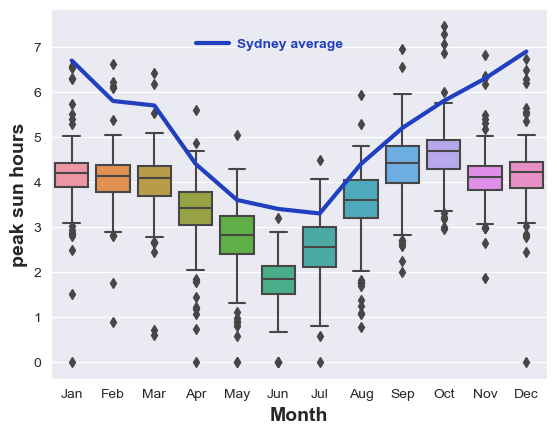

In [42]:
list_month_abbr = [calendar.month_abbr[x] for x in range(1,13)]
Sydney_psh = [6.7, 5.8, 5.7, 4.4, 3.6, 3.4, 3.3, 4.4, 5.2, 5.8, 6.3, 6.9]

sns.reset_defaults()
sns.set_style("darkgrid")
sns.set_palette('Set1', 2, .75)
sns.color_palette("hls", 8)

fig, ax = plt.subplots()
_ = sns.boxplot(data = df_psh, x='month', y='psh')
_ = plt.plot(np.arange(0,12), Sydney_psh, linewidth=3, color='#2040C0')
#_ = plt.plot(np.arange(1,13),monthly_psh.loc[monthly_psh['customer']==60]['psh'])
_ = plt.xticks(np.arange(0,12), list_month_abbr)
_ = plt.xlabel('Month', fontsize=14, fontweight='bold')
_ = plt.ylabel('peak sun hours', fontsize=14, fontweight='bold')
_ = plt.plot([3,3.8], [7.1,7.1], linewidth=3, color='#2040C0')
ax.text(4,7,'Sydney average', color='#2040C0', fontweight='bold')
plt.show()


- calculate annual average peak sun hours for all customers and graph it as a function of system size

In [43]:
df_psh_mean = df_psh.groupby(['customer']) \
                    .agg(generator_capacity = ('generator_capacity','first'),
                         psh = ('psh','mean')) \
                 .reset_index()

system_labels = [' 1 kW',' 1.5kW',' 2 kW',' 3 kW',' 4 kW','>5 kW']
system_level = pd.cut(df_psh_mean['generator_capacity'], [0.9, 1.5, 2, 3, 4, 5, 10], labels=system_labels)
df_psh_mean['system_level'] = system_level
df_psh_mean.head()

,customer,generator_capacity,psh,system_level
0,1,3.78,3.707940,3 kW
1,3,1.00,4.268098,1 kW
2,4,1.00,3.633816,1 kW
3,5,1.00,3.460737,1 kW
4,7,2.16,4.002795,2 kW


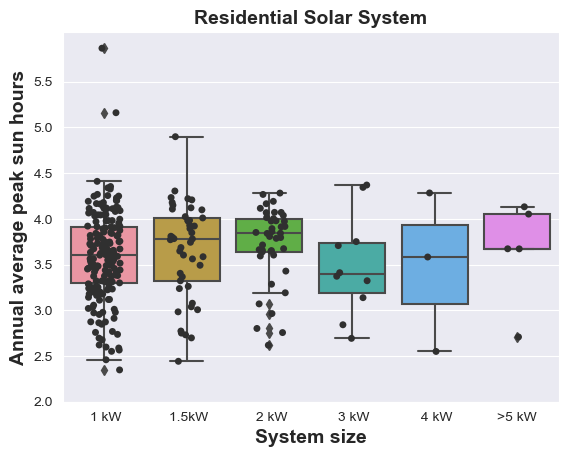

In [44]:
fig, ax = plt.subplots()
_ = sns.boxplot(data = df_psh_mean, x='system_level', y='psh')
_ = sns.stripplot(data = df_psh_mean, x='system_level', y='psh', color='#303030', jitter=0.20)
_ = plt.xlabel('System size', fontsize=14, fontweight='bold')
_ = plt.ylabel('Annual average peak sun hours', fontsize=14, fontweight='bold')
_ = plt.title('Residential Solar System', fontsize=14, fontweight='bold')
_ = plt.yticks(np.arange(2,6,0.5))
plt.show()


 - It shows that the average peak sun hours is basically similar regardless of the system size.

### Section 4.2 Solar investment <a class="anchor" id="section_4_2"></a>


 - To evaluate the solar systems from the economics point of view, here I define "solar investment" as:
> #### $$ \text{solar investment } (\frac{kWh}{$}) = \frac{\text{peak sun hours }(hr) * \text{system size }(kW)}{\text{system cost } ($)} $$

 - "Solar investment" indicates how much energy in kWh is generated per dollar spent. Definitely, the higher the better!

In [55]:
# solar_cost = 1161.7 * (system size in kW) + 2073.7
df_psh_mean['cost_per_kW'] = 1161.7 + 2073.7 / df_psh_mean['generator_capacity']
df_psh_mean['solar_investment'] = df_psh_mean['psh'] / df_psh_mean['cost_per_kW']

- plot solar investment as a function of system size

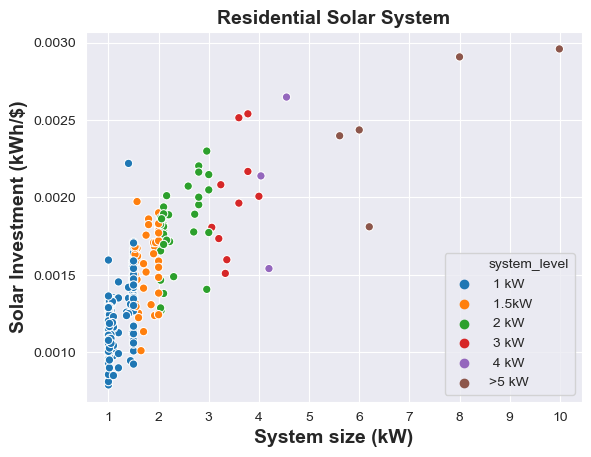

In [46]:
sns.reset_defaults()
sns.set_style("darkgrid")
#sns.set_palette('Set1', 2, .75)
#sns.color_palette("hls", 8)

fig, ax = plt.subplots()
_ = sns.scatterplot(x = 'generator_capacity',
                    y = 'solar_investment',
                    hue = 'system_level',
                    data = df_psh_mean,
                    alpha = 1,
                    hue_order = system_labels)

_ = plt.xlabel('System size (kW)', fontsize=14, fontweight='bold')
_ = plt.ylabel('Solar Investment (kWh/$)', fontsize=14, fontweight='bold')
_ = plt.title('Residential Solar System', fontsize=14, fontweight='bold')
_ = plt.xticks(np.arange(1,11,1))
#_ = plt.legend(['All time','Smart Home'])
plt.show()


### Section 4.3 Summary <a class="anchor" id="section_4_3"></a>

 - The analysis of the dataset with 300 Australian residential solar systems shows that the average payback time is 9.2 and 8.5 years when the energy plans is all time and smart home, respectively. There is a clear trend that the payback time is inversely correlated with the system size. Given that the systems performed comparably in terms of peak sun hours, solar investment in general increases with system size. The advice from this study is to install large system when the rooftop space is permitted for good system design.